In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import gc
from tqdm import tqdm
from collections import Counter
from itertools import chain
from tokenizers import (decoders, models, normalizers, pre_tokenizers, processors, trainers, Tokenizer)
from transformers import (PreTrainedTokenizerFast, Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertConfig)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy.sparse import vstack as spvstack
from scipy.special import softmax
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

2024-02-01 10:23:03.740453: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 10:23:03.740589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 10:23:03.894210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


В этом соревновании нам не предоставили данные для обучения, поэтому используем датасеты собранные умелыми участниками)

In [86]:
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
sub = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')

train = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv", sep=',')

train

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
...,...,...,...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44864,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44865,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44866,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True


### Byte-level BPE 

Вместо того чтобы выбирать традиционный путь нормализации наборов данных путем исправления опечаток, возьмем их в словарь во время токенизации

In [10]:
class BPETokenizer:
    ST = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
    
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.tok = Tokenizer(models.BPE(unk_token="[UNK]"))
        self.tok.normalizer = normalizers.Sequence([normalizers.NFC()])
        self.tok.pre_tokenizer = pre_tokenizers.ByteLevel()
        self.tok.post_processor = processors.TemplateProcessing(
            single="[CLS] $A",
            special_tokens=[("[CLS]", 1)],
        )
        
    @classmethod
    def chunk_dataset(cls, dataset, chunk_size=1_000):
        """
        Разделение датасета на части.

        Параметры:
        - dataset (pandas.DataFrame): Датасет для разделения.
        - chunk_size (int): Размер каждой части.

        Возвращает:
        - iterator: Итератор, возвращающий части датасета.
        """
        for i in range(0, len(dataset), chunk_size):
            yield dataset[i : i + chunk_size]["text"]
        
    def train(self, dataset):
        """
        Обучение токенизатора на данных.

        Параметры:
        - dataset (pandas.DataFrame): Датасет для обучения.

        Возвращает:
        - BPETokenizer: Обученный экземпляр токенизатора.
        """
        trainer = trainers.BpeTrainer(vocab_size=self.vocab_size, special_tokens=self.ST)
        dataset = Dataset.from_pandas(dataset[["text"]])
        self.tok.train_from_iterator(self.chunk_dataset(dataset), trainer=trainer)
        return self
    
    def tokenize(self, data, max_length=None):
        """
        Токенизация данных.

        Параметры:
        - data (pandas.DataFrame): Данные для токенизации.
        - max_length (int): Максимальная длина токена в последовательности.

        Возвращает:
        - list: Список токенизированных данных.
        """
        tokenized_texts = []
        for text in tqdm(data['text'].tolist()):
            tokenized_texts.append(self.tok.encode(text, max_length=max_length).tokens)
        return tokenized_texts
    
    def get_fast_tokenizer(self, max_length):
        """
        Получение быстрого токенизатора.

        Параметры:
        - max_length (int): Максимальная длина токена в последовательности.

        Возвращает:
        - PreTrainedTokenizerFast: Экземпляр быстрого токенизатора.
        """
        return PreTrainedTokenizerFast(
            tokenizer_object=self.tok,
            unk_token="[UNK]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            sep_token="[SEP]",
            mask_token="[MASK]",
            model_max_length=max_length
        )


### Метрика ROC_AUC

In [41]:
from scipy.special import softmax

def compute_roc_auc(eval_pred):
    """
    Вычисление ROC AUC для оценки модели.

    Параметры:
    - eval_pred: Результаты оценки модели.

    Возвращает:
    - dict: Словарь с ROC AUC.
    """
    logits, labels = eval_pred.predictions, eval_pred.label_ids
    
    # Если стандартное отклонение меток близко к нулю, значит, есть только один класс в наборе данных
    if labels.std() < 1e-8:
        return {"roc_auc": 0.0}
    
    # Вычисление вероятностей положительного класса с использованием softmax
    ps = softmax(logits, axis=-1)[:, 1]
    
    # Вычисление ROC AUC
    return {"roc_auc": roc_auc_score(labels, ps)}


### Датасет

In [12]:
class DAIGTDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_data, labels):
        """
        Инициализация пользовательского набора данных для модели.

        Параметры:
        - tokenized_data (dict): Токенизированные данные, полученные от токенизатора.
        - labels (numpy.ndarray): Метки классов (если не указаны, создаются метки нулей).
        """
        self.tokenized_data = tokenized_data
        if labels is not None:
            self.labels = labels
        else:
            self.labels = np.zeros(self.tokenized_data.input_ids.shape[0], dtype="int")

    def __getitem__(self, idx):
        """
        Получение элемента набора данных по индексу.

        Параметры:
        - idx (int): Индекс элемента.

        Возвращает:
        - dict: Словарь с токенизированными данными и меткой класса.
        """
        item = {key: val[idx] for key, val in self.tokenized_data.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Получение общего количества элементов в наборе данных.

        Возвращает:
        - int: Общее количество элементов.
        """
        return self.labels.shape[0]


### Решение

In [13]:
%%time
# Инициализация BPE-токенизатора с указанием размера словаря
bpe_tok = BPETokenizer(10_000)

# Обучение токенизатора на объединенных данных из тренировочного и тестового наборов
bpe_tok = bpe_tok.train(pd.concat((train, test)).reset_index(drop=True))




CPU times: user 1min 14s, sys: 868 ms, total: 1min 15s
Wall time: 20.2 s


In [15]:
train_data, val_data = train_test_split(train, random_state=228, test_size=0.2)

In [16]:
# Токенизация тренировочных данных
train_data_tokenized = tokenizer(
            train_data.text.tolist(), 
            max_length=2048, 
            padding="max_length", 
            return_tensors="pt",
            truncation=True
        )

In [17]:
# Токенизация валидационных данных
val_data_tokenized = tokenizer(
            val_data.text.tolist(), 
            max_length=2048, 
            padding="max_length", 
            return_tensors="pt",
            truncation=True
        )

In [55]:
# Создание тренировочного набора данных
train_dataset = DAIGTDataset(train_data_tokenized, labels = train_data['label'].values)

# Создание валидационного набора данных
val_dataset = DAIGTDataset(val_data_tokenized, labels = val_data['label'].values)


In [51]:
train_data

,text,label,prompt_name,source,RDizzl3_seven
25613,Asking for advice could indeed help you with t...,0,Seeking multiple opinions,persuade_corpus,False
34596,"Hey, Mrs. Johnson! 😃\n\nFor this assignment, I...",1,Grades for extracurricular activities,llama2_chat,False
20853,"Well i would choose , allow students to bring ...",0,Cell phones at school,persuade_corpus,False
4683,Summer is a students time to relax and take a ...,0,Summer projects,persuade_corpus,False
37990,\nSeeking multiple opinions when making an imp...,1,Seeking multiple opinions,darragh_claude_v6,False
...,...,...,...,...,...
13432,"The planet, Cydonia was discoved to have a fac...",0,The Face on Mars,persuade_corpus,True
8472,The Challenges that we have in our world of te...,0,Exploring Venus,persuade_corpus,True
8748,"The author's claim in the article ""The Challen...",0,Exploring Venus,persuade_corpus,True
42867,The elector college is a controversial subject...,0,Does the electoral college work?,train_essays,True


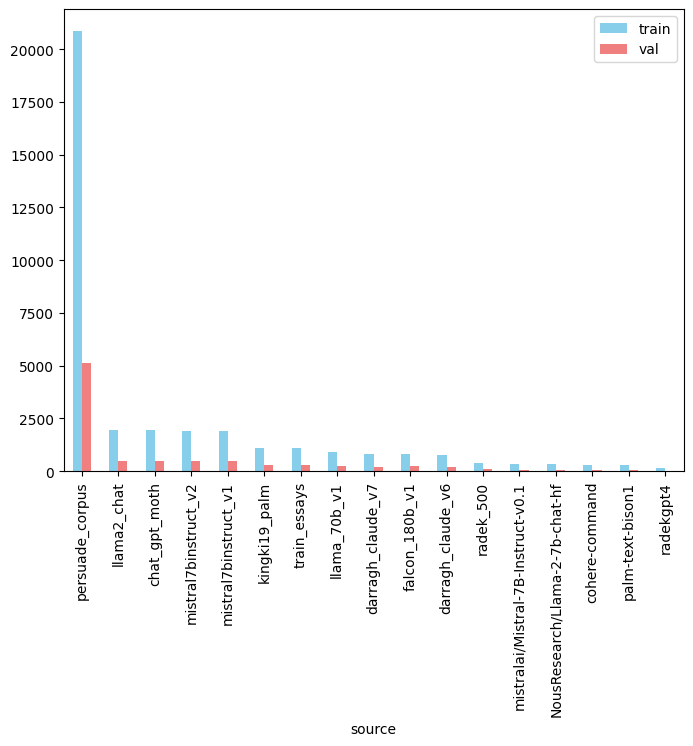

In [80]:
# Создаем DataFrame, содержащий информацию о распределении значения 'source' в тренировочных и валидационных данных
source_distribution = pd.concat((
    train_data.source.value_counts().rename("train"),
    val_data.source.value_counts().rename("val")
), axis=1)

# Строим столбчатую диаграмму
source_distribution.plot.bar(figsize=(8, 6), color=['skyblue', 'lightcoral'])

# Отображаем диаграмму
plt.show()


In [63]:
db_model = DistilBertForSequenceClassification(db_config)

args = TrainingArguments(
    output_dir = '/kaggle/working/res',
    evaluation_strategy = "steps",
    save_strategy = "steps",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='roc_auc',
    warmup_steps=500,               
    logging_dir="logs",            
    logging_steps=500
    eval_steps=500,
)

trainer = Trainer(
    model=db_model,                     
    args=args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,           
    compute_metrics=compute_roc_auc,
)

In [64]:
trainer.train()

Step,Training Loss,Validation Loss,Roc Auc
500,0.405300,0.082338,0.996582
1000,0.060100,0.036922,0.998918
1500,0.043200,0.034138,0.999374
2000,0.033000,0.019112,0.999601
2500,0.023200,0.021287,0.999645
3000,0.015600,0.017640,0.999692
3500,0.011600,0.019510,0.999719
4000,0.011200,0.015378,0.999735


TrainOutput(global_step=4488, training_loss=0.06834172458784678, metrics={'train_runtime': 6305.4874, 'train_samples_per_second': 11.385, 'train_steps_per_second': 0.712, 'total_flos': 1.928098480393421e+16, 'train_loss': 0.06834172458784678, 'epoch': 2.0})

In [65]:
%%time

# Токенизация тестовых данных
test_data_tokenized = tokenizer(
    test.text.tolist(),
    max_length=2048,
    padding="max_length",
    return_tensors="pt",
    truncation=True
)

# Создание тестового набора данных
test_dataset = DAIGTDataset(test_data_tokenized)

# Предсказание с использованием обученного тренера
test_predictions = trainer.predict(test_dataset)

# Получение вероятностей положительного класса с использованием softmax
test_predictions = softmax(test_predictions.predictions, axis=-1)[:, 1]

# Вывод вероятностей положительного класса
test_predictions


CPU times: user 83.2 ms, sys: 2.01 ms, total: 85.2 ms
Wall time: 82.1 ms


array([9.9454546e-01, 9.9998116e-01, 2.8087027e-04], dtype=float32)

In [66]:
test["generated"] = test_predictions
test

,id,prompt_id,text,generated
0,0000aaaa,2,Aaa bbb ccc.,0.994545
1,1111bbbb,3,Bbb ccc ddd.,0.999981
2,2222cccc,4,CCC ddd eee.,0.000281


In [76]:
def dummy(text):
    return text

vectorizer = TfidfVectorizer(
    ngram_range   = (3, 5), 
    lowercase     = False, 
    sublinear_tf  = True, 
    analyzer      = 'word',
    tokenizer     = dummy,
    preprocessor  = dummy,
    token_pattern = None, 
    strip_accents ='unicode')


vectorizer.fit(train_data_tokenized)

vocab = vectorizer.vocabulary_
print(vocab)

vectorizer = TfidfVectorizer(
    ngram_range    = (3, 5), 
    lowercase      = False, 
    sublinear_tf   = True, 
    vocabulary     = vocab,
    analyzer       = 'word',
    tokenizer      = dummy,
    preprocessor   = dummy,
    token_pattern  = None, 
    strip_accents  ='unicode')

tf_train = vectorizer.fit_transform(train_data_tokenized)
tf_test = vectorizer.transform(test_data_tokenized)
del vectorizer
gc.collect()

{'i n p': 22, 'n p u': 39, 'p u t': 54, 'u t _': 75, 't _ i': 57, '_ i d': 0, 'i d s': 21, 'i n p u': 23, 'n p u t': 40, 'p u t _': 55, 'u t _ i': 76, 't _ i d': 58, '_ i d s': 1, 'i n p u t': 24, 'n p u t _': 41, 'p u t _ i': 56, 'u t _ i d': 77, 't _ i d s': 59, 't o k': 66, 'o k e': 45, 'k e n': 28, 'e n _': 15, 'n _ t': 36, '_ t y': 5, 't y p': 72, 'y p e': 78, 'p e _': 51, 'e _ i': 12, 't o k e': 67, 'o k e n': 46, 'k e n _': 29, 'e n _ t': 16, 'n _ t y': 37, '_ t y p': 6, 't y p e': 73, 'y p e _': 79, 'p e _ i': 52, 'e _ i d': 13, 't o k e n': 68, 'o k e n _': 47, 'k e n _ t': 30, 'e n _ t y': 17, 'n _ t y p': 38, '_ t y p e': 7, 't y p e _': 74, 'y p e _ i': 80, 'p e _ i d': 53, 'e _ i d s': 14, 'a t t': 9, 't t e': 69, 't e n': 60, 'e n t': 18, 'n t i': 42, 't i o': 63, 'i o n': 25, 'o n _': 48, 'n _ m': 33, '_ m a': 2, 'm a s': 31, 'a s k': 8, 'a t t e': 10, 't t e n': 70, 't e n t': 61, 'e n t i': 19, 'n t i o': 43, 't i o n': 64, 'i o n _': 26, 'o n _ m': 49, 'n _ m a': 34, 

3179

In [77]:
y_train_label = train['label'].values

Теперь предсказания нашего берта совмещаем VotingClassifier

In [78]:
if len(test.text.values) <= 5:
    sub.to_csv('submission.csv', index=False)
else:
    clf = MultinomialNB(alpha=0.0225)
    
    sgd_model = SGDClassifier(
        max_iter     = 9000, 
        tol          = 1e-4, 
        random_state = 6743,
        loss         = "modified_huber"
    ) 
    
    p={
        'verbose'          : -1,
        'n_iter'           : 3000,
        'colsample_bytree' : 0.7800,
        'colsample_bynode' : 0.8000, 
        'random_state'     : 6743,
        'metric'           : 'auc',
        'objective'        : 'cross_entropy',
        'learning_rate'    : 0.00581909898961407, 
      }
    lgb=LGBMClassifier(**p)
    
    
    cat = CatBoostClassifier(
        iterations        = 3000,
        verbose           = 0,
        subsample         = 0.35,
        random_seed       = 6543,
        allow_const_label = True,
        loss_function     = 'CrossEntropy',
        learning_rate     = 0.005599066836106983,
    )
    
    
    ensemble = VotingClassifier(
        estimators = [('mnb', clf),
                      ('sgd', sgd_model),
                      ('lgb', lgb), 
                      ('cat', cat)],
        weights    = [0.07, 0.23, 0.2, 0.5], 
        voting     = 'soft', 
        n_jobs     = -1
    )
    
    ensemble.fit(tf_train, y_train_label)
    gc.collect()
    
    final_preds = ensemble.predict_proba(tf_test)[:,1]
    sub['generated'] = final_preds * 0.7 + p_db * 0.3
sub.to_csv('submission.csv', index=False)

## Итоги

Не успел попробовать ROBERTAForSequenceClassification

Оказалось, что catboost и sgd обучились лучше всего и некоторые просто брали медальки, увеличив их долю в VotingClassifier

Не выбрал это решение, лишившись серебра (у меня 0.907, а серебро начиналось с 0.904). 

В результате вообще не удалось получить медальку

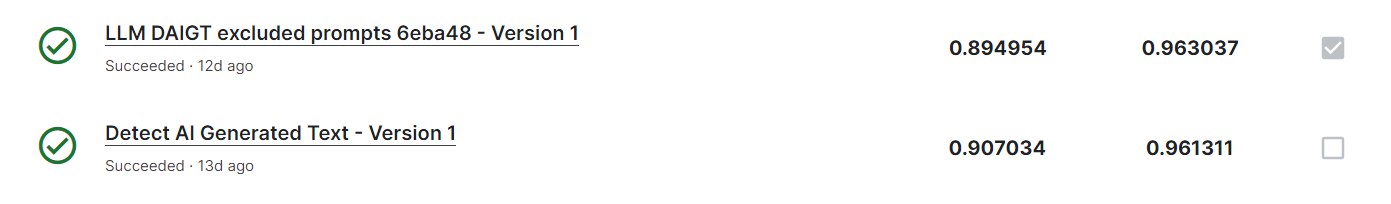